In [1]:

import statsmodels.api as sm #for OLS regression
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt #for heatmap plotting
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns #for heatmap plotting
from statsmodels.iolib.summary2 import summary_col #to summarize multiple regressions in one table
from datetime import date
from dateutil.relativedelta import relativedelta
import math
from scipy import stats

In [12]:
pf_size = pd.read_csv('C:/Users/yzou/Desktop/Portfolios_Formed_on_ME_daily.csv')
ff5 = pd.read_csv('C:/Users/yzou/Desktop/F-F_Research_Data_5_Factors_2x3_daily.csv')

In [13]:
pf_size.rename(columns = {'Unnamed: 0': 'YYMM'}, inplace = True)
ff5.rename(columns = {'Unnamed: 0': 'YYMM'}, inplace = True)

In [14]:
#to convert to decile format and get excess returns
pf_size_excess=(pf_size.iloc[:,1:pf_size.shape[1]]).sub(ff5.RF,axis=0)
print(pf_size_excess.head())

      <= 0  Lo 30  Med 40  Hi 30  Lo 20  Qnt 2  Qnt 3  Qnt 4  Hi 20  Lo 10  \
0 -100.002 -0.592  -0.552 -0.682 -0.622 -0.702 -0.482 -0.572 -0.692 -0.652   
1 -100.002  0.428   0.578  0.838  0.488  0.608  0.528  0.708  0.838  0.368   
2 -100.002  0.538   0.568  0.638  0.508  0.558  0.608  0.608  0.638  0.398   
3 -100.002  0.318   0.328  0.418  0.398  0.278  0.358  0.278  0.428  0.348   
4 -100.002 -0.442  -0.542 -0.642 -0.362 -0.752 -0.632 -0.372 -0.672 -0.482   

   2-Dec  3-Dec  4-Dec  5-Dec  6-Dec  7-Dec  8-Dec  9-Dec  Hi 10  
0 -0.592 -0.552 -0.822 -0.562 -0.422 -0.532 -0.602 -0.702 -0.692  
1  0.608  0.318  0.848  0.488  0.548  0.538  0.808  0.638  0.878  
2  0.618  0.598  0.528  0.388  0.768  0.548  0.648  0.618  0.638  
3  0.468  0.168  0.378  0.398  0.328  0.278  0.278  0.298  0.458  
4 -0.232 -0.592 -0.872 -0.652 -0.612 -0.312 -0.402 -0.482 -0.712  


In [15]:
ff5['YYMM'] = pd.to_datetime(ff5['YYMM'],yearfirst=True, format='%Y%m%d')
pf_size_excess['YYMM'] = pd.to_datetime(pf_size['YYMM'],yearfirst=True, format='%Y%m%d')
print(ff5.head())
print(pf_size_excess.head())

        YYMM  Mkt-RF   SMB   HML   RMW   CMA     RF
0 1963-07-01   -0.67  0.00 -0.32 -0.01  0.15  0.012
1 1963-07-02    0.79 -0.27  0.27 -0.07 -0.19  0.012
2 1963-07-03    0.63 -0.17 -0.09  0.17 -0.33  0.012
3 1963-07-05    0.40  0.08 -0.28  0.08 -0.33  0.012
4 1963-07-08   -0.63  0.04 -0.18 -0.29  0.13  0.012
      <= 0  Lo 30  Med 40  Hi 30  Lo 20  Qnt 2  Qnt 3  Qnt 4  Hi 20  Lo 10  \
0 -100.002 -0.592  -0.552 -0.682 -0.622 -0.702 -0.482 -0.572 -0.692 -0.652   
1 -100.002  0.428   0.578  0.838  0.488  0.608  0.528  0.708  0.838  0.368   
2 -100.002  0.538   0.568  0.638  0.508  0.558  0.608  0.608  0.638  0.398   
3 -100.002  0.318   0.328  0.418  0.398  0.278  0.358  0.278  0.428  0.348   
4 -100.002 -0.442  -0.542 -0.642 -0.362 -0.752 -0.632 -0.372 -0.672 -0.482   

   2-Dec  3-Dec  4-Dec  5-Dec  6-Dec  7-Dec  8-Dec  9-Dec  Hi 10       YYMM  
0 -0.592 -0.552 -0.822 -0.562 -0.422 -0.532 -0.602 -0.702 -0.692 1963-07-01  
1  0.608  0.318  0.848  0.488  0.548  0.538  0.808  0.638  0.87

In [16]:
#change timestamps to index and delete unnecessary columns
ff5.index = ff5['YYMM']
pf_size_excess.index = pf_size_excess['YYMM']
ff5 = ff5.drop('YYMM', axis = 1)
# pf_size_excess = pf_size_excess.drop('YYMM', axis = 1)
ff5 = ff5.drop('RF', axis = 1)
#choose the size cut method
pf_size_excess = pf_size_excess.loc[:,['Lo 20', 'Qnt 2', 'Qnt 3','Qnt 4', 'Hi 20']]

print(pf_size_excess.head())

            Lo 20  Qnt 2  Qnt 3  Qnt 4  Hi 20
YYMM                                         
1963-07-01 -0.622 -0.702 -0.482 -0.572 -0.692
1963-07-02  0.488  0.608  0.528  0.708  0.838
1963-07-03  0.508  0.558  0.608  0.608  0.638
1963-07-05  0.398  0.278  0.358  0.278  0.428
1963-07-08 -0.362 -0.752 -0.632 -0.372 -0.672


In [17]:
us_crisis_1 = ['1973-10-19', '1975-2-28', 'OPEC Oil Embargo']
us_crisis_2 = ['1981-1-1', '1982-6-30', 'US Recession of 1981-1982']
us_crisis_3 = ['1989-9-30', '1991-3-30', 'Junk Bonk Crash/S&L Crisis']
us_crisis_4 = ['2001-9-11', '2003-6-30', '911 Attack']
us_crisis_5 = ['2007-8-1', '2009-7-1', '2008 Financial Crisis']
us_crisis_6 = ['2018-12-1', '2019-5-30', 'China-US Trade War']

other_crisis_1 = ['1997-9-1', '1998-6-30', 'Asia Crisis']
other_crisis_2 = ['1997-9-1', '1998-12-30', 'Russia Crisis']
other_crisis_3 = ['2001-1-1','2001-12-30', 'Dotcom Bubble Burst']
other_crisis_4 = ['2010-1-1', '2012-6-30', 'European Debt Crisis']
other_crisis_5 = ['2015-6-12','2015-10-30', 'Chinese Market Crash']
other_crisis_6 = ['2015-1-1', '2015-12-30', 'Swiss Franc Shock']


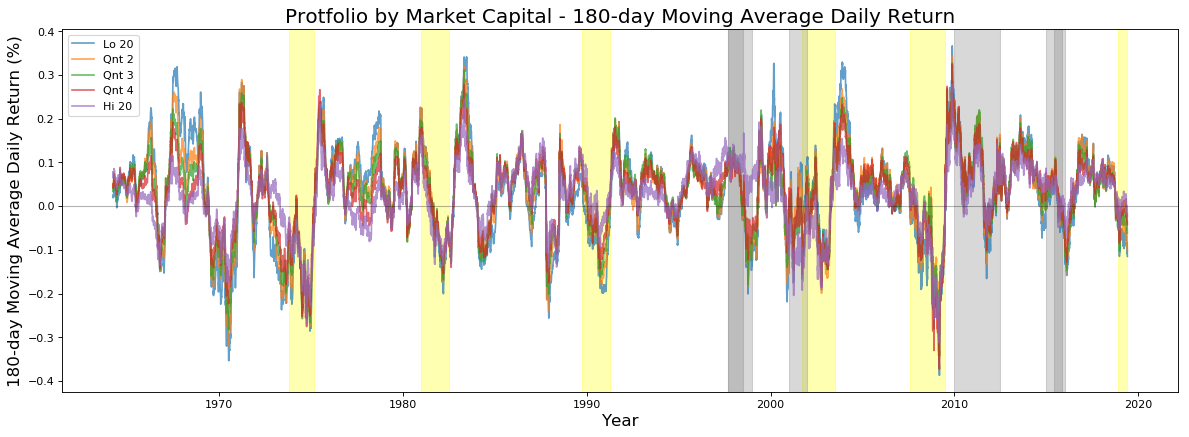

In [18]:
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

rolling_mean_Lo = pf_size_excess.loc[:,'Lo 20'].rolling(window=180).mean()
plt.plot(rolling_mean_Lo, label='Lo 20',alpha = 0.7)
rolling_mean_Q2 = pf_size_excess.loc[:,'Qnt 2'].rolling(window=180).mean()
plt.plot(rolling_mean_Q2, label='Qnt 2',alpha = 0.7)
rolling_mean_Q3 = pf_size_excess.loc[:,'Qnt 3'].rolling(window=180).mean()
plt.plot(rolling_mean_Q3, label='Qnt 3',alpha = 0.7)

rolling_mean_Q4 = pf_size_excess.loc[:,'Qnt 4'].rolling(window=180).mean()
plt.plot(rolling_mean_Q4, label='Qnt 4',alpha = 0.7)
rolling_mean_Hi = pf_size_excess.loc[:,'Hi 20'].rolling(window=180).mean()
plt.plot(rolling_mean_Hi, label='Hi 20',alpha = 0.7)

plt.legend(loc='upper left')
plt.ylabel('180-day Moving Average Daily Return (%)', size = 15)
plt.xlabel('Year', size = 15)
plt.title('Protfolio by Market Capital - 180-day Moving Average Daily Return', size = 18)

plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')
plt.axhline(linewidth=1, color='black',alpha = 0.3)
plt.grid(False)

plt.show()

In [19]:
start = ff5.index[0]
end = ff5.index[ff5.shape[0]-1]
# print(end)
# window = 6
# t1 = start + relativedelta(months =+window)
# print(t1)
# n_month = (end.year - start.year)*12 + end.month - start.month + 1

n_day = end - start
print(n_day.days)
print(ff5.shape[0])
#because there are weekends and public holidays, we use every 126 records as a proxy of every 6-month window
#There are in total 14075 records, thus will have 14075 - 126 + 1 =  13950 windows
window = 126
n_window = ff5.shape[0] - 126 + 1
print(n_window)

20423
14075
13950


In [20]:
#To run OLS on a 6-month rolling window basis. The logic of this loop is to run the rolling window regressions 
#for each of the 5 portfolios. That is, the first 13950 models are for the portfolio Lo 30,
#the next 13950 models are for the portfolio Med 40
models = []
for i in range (5):
    for m in range(n_window):
        
        t0 = ff5.index[0+m]
        if ff5.index[0+m+window-1] < end:
            t1 = ff5.index[0+m+window-1]
        else:
            t1 = end
        
        x = ff5[t0:t1]
        x = sm.add_constant(x)
        y = pf_size_excess[t0:t1]
        reg = sm.OLS(y.iloc[:,i], x)
        
        models.append(reg.fit())
        
print(models[0].summary())

                            OLS Regression Results                            
Dep. Variable:                  Lo 20   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     391.3
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           1.69e-72
Time:                        20:30:30   Log-Likelihood:                 83.037
No. Observations:                 126   AIC:                            -154.1
Df Residuals:                     120   BIC:                            -137.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0282      0.012     -2.415      0.0

In [45]:
print(window)
window_nm = []
for i in range(n_window):
    nm = ff5.index[i+int(window/2)]
    window_nm.append(nm)
print(len(window_nm))
print(window_nm[0])
print(window_nm[179])

126
13950
1963-09-30 00:00:00
1964-06-17 00:00:00


In [24]:
#In a loop, collect the constant terms from 47 regressions of each of the 25 portfolios
Constant = {}
for i in range(5):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[0]) 
    Constant["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the coefficient of Mrk-Rf each of the 3 portfolios
Mrk = {}
for i in range(5):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[1]) 
    Mrk["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the coefficient of SMB each of the 3 portfolios
SMB = {}
for i in range(5):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[2]) 
    SMB["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the coefficient of HML each of the 3 portfolios
HML = {}
for i in range(5):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[3]) 
    HML["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the coefficient of RMW each of the 3 portfolios
RMW = {}
for i in range(5):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[4]) 
    RMW["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

#In a loop, collect the coefficient of CMA each of the 3 portfolios
CMA = {}
for i in range(5):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[5]) 
    CMA["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

In [36]:
#In a loop, collect the R-squared each of the 3 portfolios
Rsquare = {}
for i in range(5):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].rsquared) 
    Rsquare["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

In [26]:
portfolio = pf_size_excess.columns

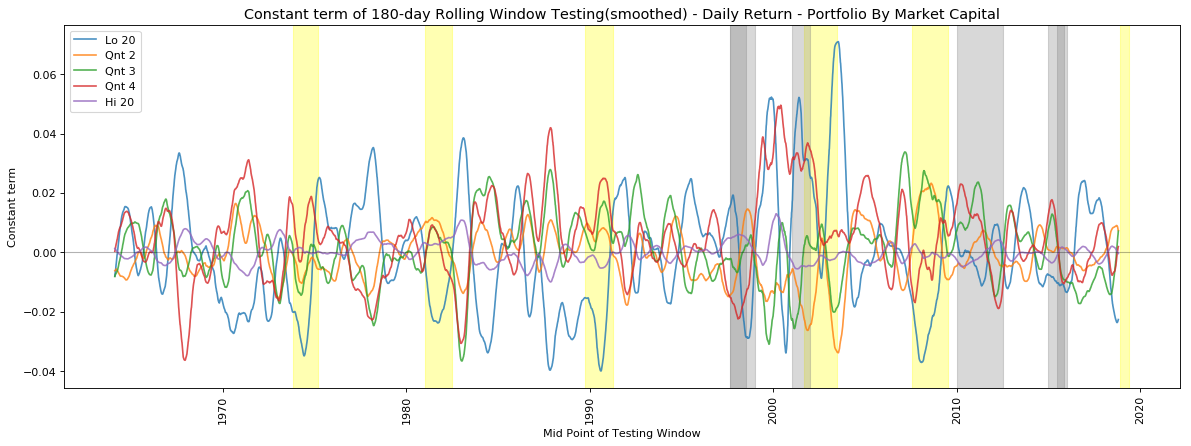

In [65]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    rolling_mean = Constant["Portfoio{0}".format(i)].rolling(window=180, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Constant term', size = 10, rotation = 90)
plt.title('Constant term of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

plt.axhline(linewidth=1, color='black', alpha = 0.3)
plt.grid(False)
plt.show()

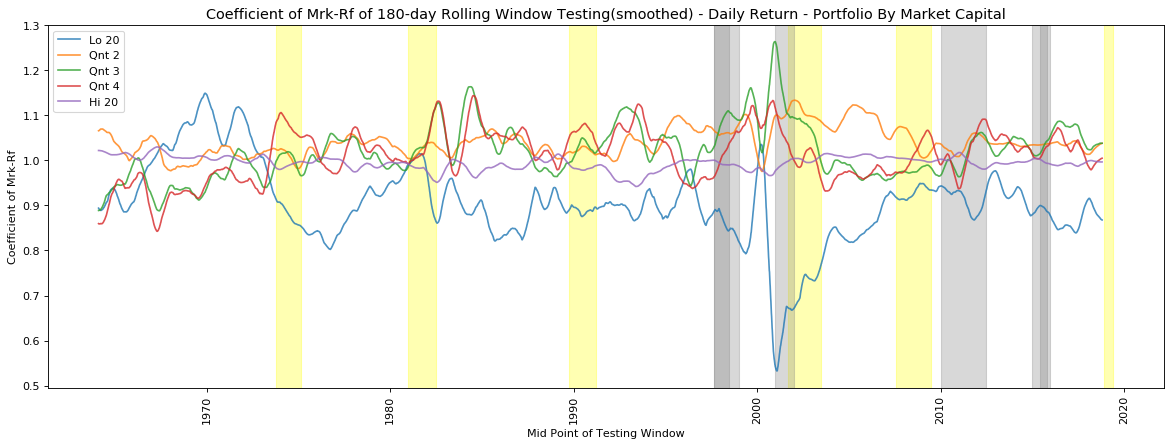

In [66]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    rolling_mean = Mrk["Portfoio{0}".format(i)].rolling(window=180, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Coefficient of Mrk-Rf', size = 10, rotation = 90)
plt.title('Coefficient of Mrk-Rf of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

# plt.axhline(y = 1.05, linewidth=1, color='black',alpha=0.3, linestyle = '--')
# plt.axhline(y = 0.95, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.grid(False)
plt.show()

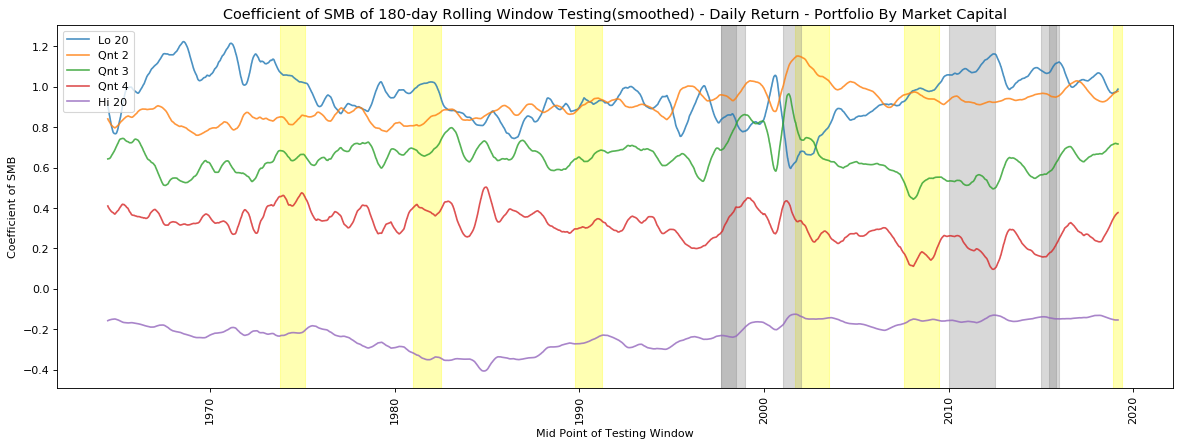

In [29]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    rolling_mean = SMB["Portfoio{0}".format(i)].rolling(window=180).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Coefficient of SMB', size = 10, rotation = 90)
plt.title('Coefficient of SMB of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

plt.grid(False)

plt.show()

In [67]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    rolling_mean = HML["Portfoio{0}".format(i)].rolling(window=180,, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Coefficient of HML', size = 10, rotation = 90)
plt.title('Coefficient of HML of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

# plt.axhline(y = 0.1, linewidth=1, color='black',alpha=0.3, linestyle = '--')
# plt.axhline(y = 0, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.grid(False)

plt.show()

SyntaxError: invalid syntax (<ipython-input-67-1f834b70bed2>, line 4)

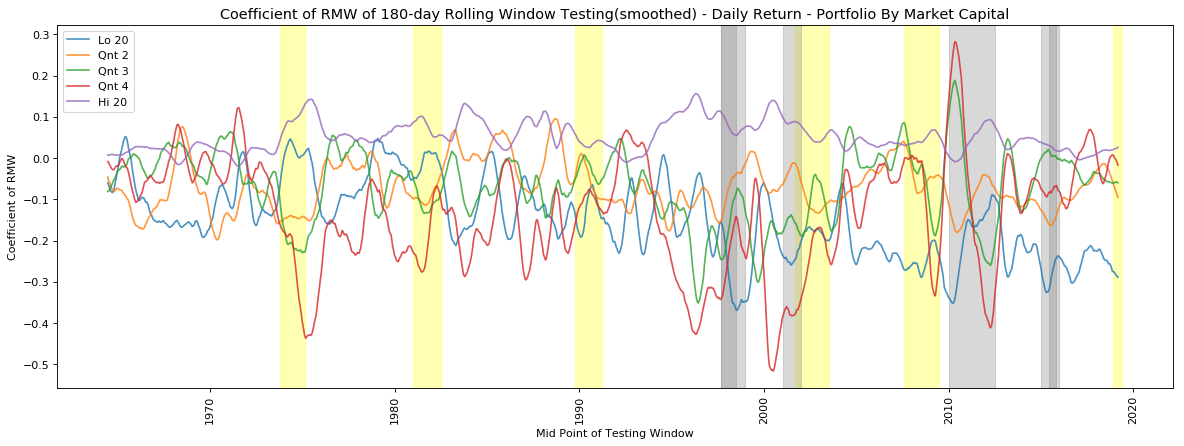

In [31]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    rolling_mean = RMW["Portfoio{0}".format(i)].rolling(window=180).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Coefficient of RMW', size = 10, rotation = 90)
plt.title('Coefficient of RMW of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

# plt.axhline(y = -0.05, linewidth=1, color='black',alpha=0.3, linestyle = '--')
# plt.axhline(y = -0.2, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.grid(False)

plt.show()

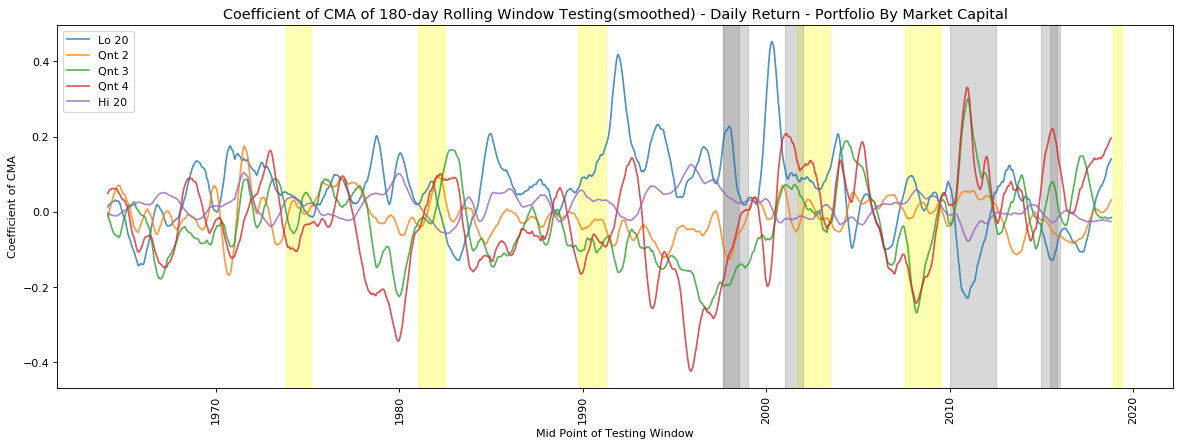

In [68]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    rolling_mean = CMA["Portfoio{0}".format(i)].rolling(window=180, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Coefficient of CMA', size = 10, rotation = 90)
plt.title('Coefficient of CMA of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

# plt.axhline(y = 0.1, linewidth=1, color='black',alpha=0.3, linestyle = '--')
# plt.axhline(y = -0.1, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.grid(False)

plt.show()

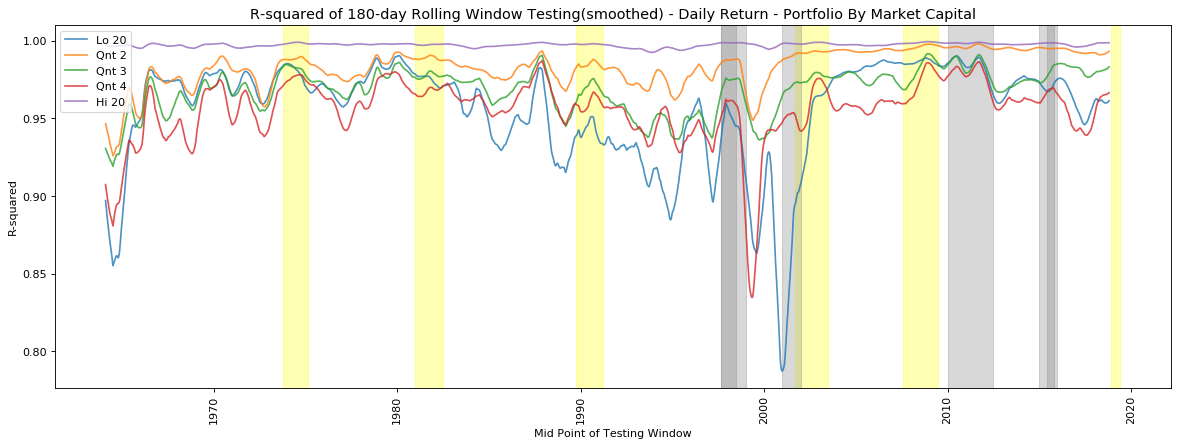

In [69]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    rolling_mean = Rsquare["Portfoio{0}".format(i)].rolling(window=180, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('R-squared', size = 10, rotation = 90)
plt.title('R-squared of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')
plt.show()

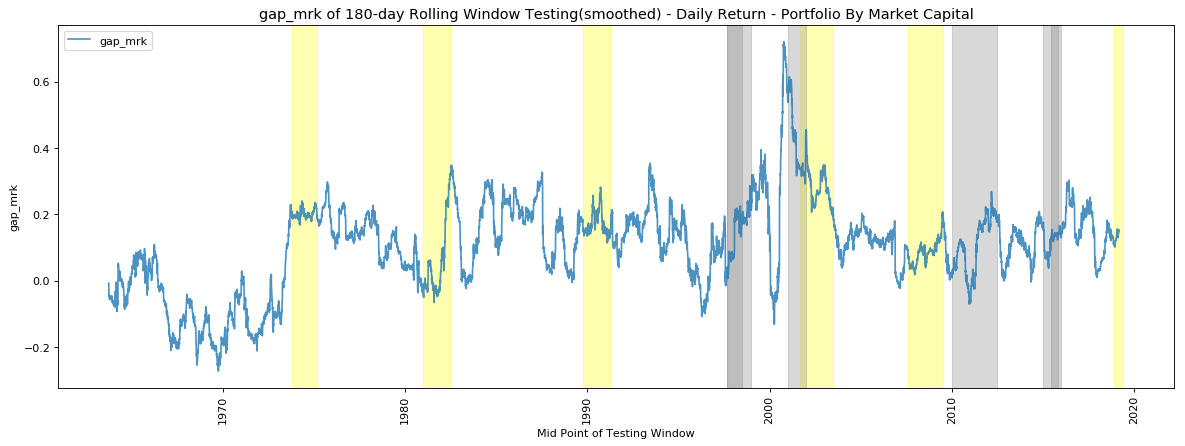

In [80]:
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
gap_mrk = Mrk["Portfoio3"] -Mrk["Portfoio0"]
plt.plot(gap_mrk,label="gap_mrk",alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('gap_mrk', size = 10, rotation = 90)
plt.title('gap_mrk of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')
plt.show()

Timestamp('1964-06-17 00:00:00')

,B
0,NaN
1,1.0
2,3.0
3,5.0
4,7.0
